# Initialization

In [ ]:
!pip install opencv-python scikit-learn matplotlib

In [ ]:
!pip install --upgrade scikit-image

# Libararies

In [ ]:
import os
import cv2
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import euclidean_distances

In [ ]:
import skimage.feature
from skimage.feature.texture import graycomatrix

# Dataset Preperation

In [ ]:
from google.colab import userdata
import os

userdata = {
    'KAGGLE_KEY': '',
    'KAGGLE_USERNAME': ''
}

os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')

In [ ]:
!kaggle datasets download -d moltean/fruits

Dataset URL: https://www.kaggle.com/datasets/moltean/fruits
License(s): CC-BY-SA-4.0
 99% 956M/964M [00:09<00:00, 91.4MB/s]
100% 964M/964M [00:09<00:00, 107MB/s] 


In [ ]:
!unzip "/content/fruits.zip" #1GB

Streaming output truncated to the last 5000 lines.
  inflating: fruits-360_dataset_original-size/fruits-360-original-size/Training/apple_red_yellow_1/r0_96.jpg  
  inflating: fruits-360_dataset_original-size/fruits-360-original-size/Training/apple_red_yellow_1/r0_98.jpg  
  inflating: fruits-360_dataset_original-size/fruits-360-original-size/Training/apple_red_yellow_1/r1_0.jpg  
  inflating: fruits-360_dataset_original-size/fruits-360-original-size/Training/apple_red_yellow_1/r1_10.jpg  
  inflating: fruits-360_dataset_original-size/fruits-360-original-size/Training/apple_red_yellow_1/r1_100.jpg  
  inflating: fruits-360_dataset_original-size/fruits-360-original-size/Training/apple_red_yellow_1/r1_102.jpg  
  inflating: fruits-360_dataset_original-size/fruits-360-original-size/Training/apple_red_yellow_1/r1_104.jpg  
  inflating: fruits-360_dataset_original-size/fruits-360-original-size/Training/apple_red_yellow_1/r1_106.jpg  
  inflating: fruits-360_dataset_original-size/fruits-360-o

In [ ]:
def load_images_from_folder(base_dir):
    images = []
    labels = []
    for fruit_dir in os.listdir(base_dir):
        fruit_path = os.path.join(base_dir, fruit_dir)
        if os.path.isdir(fruit_path):
            for filename in os.listdir(fruit_path):
                img_path = os.path.join(fruit_path, filename)
                img = cv2.imread(img_path)
                if img is not None:
                    images.append(img)
                    labels.append(fruit_dir)
    return np.array(images), np.array(labels)

In [ ]:
train_images, train_labels = load_images_from_folder('/content/fruits-360_dataset_100x100/fruits-360/Training')
#test_images, test_labels = load_images_from_folder('/content/fruits-360_dataset_100x100/fruits-360/Test')

# Feature Extraction

In [ ]:
def extract_color_histogram(image, bins=(8, 8, 8)):
    hist = cv2.calcHist([image], [0, 1, 2], None, bins, [0, 256, 0, 256, 0, 256])
    hist = cv2.normalize(hist, hist).flatten()
    return hist

In [ ]:
def extract_glcm(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    glcm = skimage.feature.graycomatrix(gray_image, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    return glcm.flatten()[:10]  # Return the first 10 features for simplicity

In [ ]:
def extract_hu_moments(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    moments = cv2.moments(gray_image)
    hu_moments = cv2.HuMoments(moments).flatten()
    return hu_moments

In [ ]:
def extract_lbp(image, num_points=24, radius=8):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    lbp = skimage.feature.local_binary_pattern(gray_image, num_points, radius, method="uniform")
    (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, num_points + 3), range=(0, num_points + 2))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-6)  # Normalize the histogram
    return hist

In [ ]:
def extract_hog(image, pixels_per_cell=(8, 8), cells_per_block=(2, 2), orientations=9):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    hog = skimage.feature.hog(
        gray_image,
        orientations=orientations,
        pixels_per_cell=pixels_per_cell,
        cells_per_block=cells_per_block,
        block_norm='L2-Hys',
        transform_sqrt=True,
        feature_vector=True
    )
    return hog

In [ ]:
def extract_features(image):
    color_hist = extract_color_histogram(image)
    glcm_features = extract_glcm(image)
    hu_moments = extract_hu_moments(image)
    lbp_features = extract_lbp(image)
    hog_features = extract_hog(image)

    # Combine all features into a single vector
    return np.hstack([color_hist, glcm_features, hu_moments, lbp_features, hog_features])

In [ ]:
num_images = len(train_images)   # Total number of training images
num_features = 4911  # Total number of features (e.g., color hist, GLCM, Hu, LBP, HOG)

In [ ]:
#train_features = np.array([extract_features(img) for img in train_images])
# test_features = np.array([extract_features(img) for img in test_images])

# Memory-mapped file to store extracted features
memmapped_array = np.memmap('train_features.dat', dtype='float32', mode='w+', shape=(num_images, num_features))

# Loop through each image, extract features, and store them in the memory-mapped array
for i, img in enumerate(train_images):
    memmapped_array[i] = extract_features(img)

# Flush to disk to ensure all data is written
memmapped_array.flush()

# Dimentionality Reduction

In [ ]:
# Reopen the memory-mapped file to read the features
train_features = np.memmap('train_features.dat', dtype='float32', mode='r', shape=(num_images, num_features))

In [ ]:
batch_size = 100
pca = IncrementalPCA(n_components=50)

# Fit IncrementalPCA in batches
for i in range(0, num_images, batch_size):
    # Load a batch of features
    batch = train_features[i:i+batch_size]

    # Incrementally fit the PCA model on the current batch
    pca.partial_fit(batch)

# Now, transform the entire dataset in batches to get reduced features
train_features_reduced = np.memmap('train_features_reduced.dat', dtype='float32', mode='w+', shape=(num_images, 50))

for i in range(0, num_images, batch_size):
    batch = train_features[i:i+batch_size]

    # Transform the batch
    train_features_reduced[i:i+batch_size] = pca.transform(batch)

# SVM Implementation

In [ ]:
from sklearn import svm
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [ ]:
# Step 1: Prepare the labels (encode them if necessary)
le = LabelEncoder()
encoded_labels = le.fit_transform(train_labels)

In [ ]:
# Step 2: Train the SVM
svm_model = make_pipeline(StandardScaler(), svm.SVC(kernel='rbf', probability=True))
svm_model.fit(train_features_reduced, encoded_labels)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(probability=True))])

# Identification of Closest Fruits and Vegetables

In [ ]:
def identify_bordering_fruits(target_fruit, distance_threshold=0.1, batch_size=100):
    target_index = le.transform([target_fruit])[0]

    target_vector = train_features_reduced[encoded_labels == target_index].mean(axis=0)

    bordering_fruits = []

    num_images = len(train_features_reduced)
    for i in range(0, num_images, batch_size):
        batch = train_features_reduced[i:i + batch_size]
        distances = svm_model.decision_function(batch)

        for j, distance in enumerate(distances):
            # Only compare non-target fruits
            fruit_label = encoded_labels[i + j]
            print(type(target_vector[0]),target_vector[0], type(distance_threshold))
            if abs(distance - svm_model.decision_function([target_vector])[0]) < distance_threshold and fruit_label != target_index:
                bordering_fruits.append((le.inverse_transform([fruit_label])[0], distance))

    return bordering_fruits

In [ ]:
#NEW VERSION

from sklearn.metrics.pairwise import euclidean_distances

def identify_bordering_fruits_new(target_fruit, distance_threshold=0.5, batch_size=100):
    target_index = le.transform([target_fruit])[0]

    # Get the feature vector of the target fruit (average of all similar samples)
    target_vector = train_features_reduced[encoded_labels == target_index].mean(axis=0)

    bordering_fruits = []

    num_images = len(train_features_reduced)
    for i in range(0, num_images, batch_size):
        batch = train_features_reduced[i:i + batch_size]
        distances = svm_model.decision_function(batch)

        # Ensure we calculate the SVM decision function for the target fruit
        target_distance = svm_model.decision_function([target_vector])[0]  # Scalar output expected

        for j, distance in enumerate(distances):
            fruit_label = encoded_labels[i + j]

            # Calculate Euclidean distance between the target vector and the current fruit
            fruit_vector = train_features_reduced[i + j]
            euclidean_dist = np.linalg.norm(target_vector - fruit_vector)  # Euclidean distance between vectors

            # Use the euclidean distance to determine bordering fruits
            if euclidean_dist < distance_threshold and fruit_label != target_index:
                bordering_fruits.append((le.inverse_transform([fruit_label])[0], euclidean_dist))

    return bordering_fruits


In [ ]:
target_fruit_name = 'Apple Golden 1' #'Kiwi 1'
bordering_fruits = identify_bordering_fruits_new(target_fruit_name)
print(f"Bordering fruits for {target_fruit_name}: {bordering_fruits}")

Bordering fruits for Kiwi 1: []


# Counterfactual Explanation

In [ ]:
# Step 4: Define a function for counterfactual explanation
'''def minimal_change_to_border(target_fruit, distance_threshold=0.1):
    bordering_fruits = identify_bordering_fruits(target_fruit, distance_threshold)

    if not bordering_fruits:
        return None  # No bordering fruits found

    # Find the closest bordering fruit
    closest_bordering_fruit = min(bordering_fruits, key=lambda x: abs(x[1]))

    # Get the feature vector for the target fruit
    target_index = le.transform([target_fruit])[0]
    target_vector = train_features_reduced[encoded_labels == target_index].mean(axis=0)

    # Get the feature vector for the closest bordering fruit
    closest_fruit_index = le.transform([closest_bordering_fruit[0]])[0]
    closest_vector = train_features_reduced[encoded_labels == closest_fruit_index].mean(axis=0)

    # Calculate the required change
    change_vector = closest_vector - target_vector
    minimal_change = np.linalg.norm(change_vector)

    # New feature vector for the target fruit to be the closest bordering fruit
    new_target_vector = target_vector + (change_vector / minimal_change) * (closest_fruit_index / 2)  # Scale change

    return closest_bordering_fruit[0], new_target_vector, minimal_change'''

In [ ]:
import numpy as np
from scipy.spatial import distance

# Step 4: Define a function for counterfactual explanation
def minimal_change_to_border_new(target_fruit, distance_threshold=3):
    # Identify bordering fruits using Euclidean distance
    bordering_fruits = identify_bordering_fruits_new(target_fruit, distance_threshold)

    if not bordering_fruits:
        return None  # No bordering fruits found

    # Find the closest bordering fruit by Euclidean distance
    closest_bordering_fruit = min(bordering_fruits, key=lambda x: x[1])  # Already Euclidean distance in second element

    # Get the feature vector for the target fruit
    target_index = le.transform([target_fruit])[0]
    target_vector = train_features_reduced[encoded_labels == target_index].mean(axis=0)

    # Get the feature vector for the closest bordering fruit
    closest_fruit_index = le.transform([closest_bordering_fruit[0]])[0]
    closest_vector = train_features_reduced[encoded_labels == closest_fruit_index].mean(axis=0)

    # Calculate the required change vector
    change_vector = closest_vector - target_vector
    minimal_change = np.linalg.norm(change_vector)  # This is the Euclidean distance for the change

    # Create a new feature vector for the target fruit to be closer to the bordering fruit
    new_target_vector = target_vector + change_vector * (distance_threshold / minimal_change)

    return closest_bordering_fruit[0], new_target_vector, minimal_change




In [ ]:
import numpy as np
from scipy.spatial import distance

# Step 4: Define a function for counterfactual explanation
def minimal_change_to_border_top_three(target_fruit):
    closest_fruits = []  # To store the closest fruits across different thresholds

    # Iterate over threshold values from 1 to 100
    for distance_threshold in range(1, 101):
        # Identify bordering fruits using Euclidean distance for the current threshold
        bordering_fruits = identify_bordering_fruits_new(target_fruit, distance_threshold)

        if not bordering_fruits:
            continue  # Skip if no bordering fruits found

        # Sort bordering fruits by distance and get the three closest
        sorted_bordering_fruits = sorted(bordering_fruits, key=lambda x: x[1])[:3]

        # Add the closest fruits to the list
        closest_fruits.extend(sorted_bordering_fruits)

    # Find the minimum distance among the closest fruits
    if not closest_fruits:
        return None  # No bordering fruits found across all thresholds

    # Get unique closest fruits and their distances
    unique_closest_fruits = {fruit[0]: fruit[1] for fruit in closest_fruits}

    # Find the three closest fruits
    three_closest_fruits = sorted(unique_closest_fruits.items(), key=lambda x: x[1])[:3]

    # Calculate the new feature vector for the closest fruit
    closest_fruit_name, closest_distance = three_closest_fruits[0]

    # Get the feature vector for the target fruit
    target_index = le.transform([target_fruit])[0]
    target_vector = train_features_reduced[encoded_labels == target_index].mean(axis=0)

    # Get the feature vector for the closest bordering fruit
    closest_fruit_index = le.transform([closest_fruit_name])[0]
    closest_vector = train_features_reduced[encoded_labels == closest_fruit_index].mean(axis=0)

    # Calculate the required change vector
    change_vector = closest_vector - target_vector
    minimal_change = np.linalg.norm(change_vector)  # This is the Euclidean distance for the change

    # Create a new feature vector for the target fruit to be closer to the bordering fruit
    new_target_vector = target_vector + change_vector * (closest_distance / minimal_change)

    return closest_fruit_name, new_target_vector, minimal_change



In [ ]:
# New version
target_fruit_name = 'Apple Golden 1'
result = minimal_change_to_border_top_three(target_fruit_name)#, distance_threshold=0.5)

if result is not None:
    closest_bordering_fruit, new_vector, minimal_change = result
    print(f"To make {target_fruit_name} closer to {closest_bordering_fruit}, the new feature vector would be:")
    print(new_vector)
    print(f"Minimal change required: {minimal_change:.4f}")
else:
    print(f"No bordering fruits found for {target_fruit_name}.")

'''closest_bordering_fruit, new_vector, minimal_change = minimal_change_to_border_new(target_fruit_name, distance_threshold=0.5)

if closest_bordering_fruit:
    print(f"To make {target_fruit_name} closer to {closest_bordering_fruit}, the new feature vector would be:")
    print(new_vector)
    print(f"Minimal change required: {minimal_change:.4f}")
else:
    print(f"No bordering fruits found for {target_fruit_name}.")'''

KeyboardInterrupt: 

In [ ]:
print(result)

None


In [ ]:
closest_bordering_fruit, new_vector, minimal_change = minimal_change_to_border(target_fruit_name)
print(f"To make {target_fruit_name} closer to {closest_bordering_fruit}, the new feature vector would be:")
print(new_vector)
print(f"Minimal change required: {minimal_change:.4f}")

# Prev. CE

## Given Kiwi 1, what are the items closest in distance to it and how so?

In [ ]:
# X_labels: list of fruit/vegetable labels (names)
# y_features: feature vectors of fruits/vegetables (after PCA/dimensionality reduction)

def find_nearest_neighbors(X_labels, y_features, target_fruit_name, num_neighbors=10):
    # Convert labels to a list if they are in a NumPy array
    if isinstance(X_labels, np.ndarray):
        X_labels = X_labels.tolist()

    # Find the index of the target fruit in the label list
    target_index = X_labels.index(target_fruit_name)

    # Extract the feature vector of the target fruit
    target_feature = y_features[target_index].reshape(1, -1)

    # Calculate the Euclidean distance between the target fruit's feature vector and all other feature vectors
    distances = pairwise_distances(target_feature, y_features, metric='euclidean').flatten()

    # Get the indices of the closest fruits/vegetables (excluding the target itself)
    nearest_indices = distances.argsort()[1:num_neighbors + 1]

    # Get the names and distances of the nearest fruits
    nearest_fruits = [X_labels[i] for i in nearest_indices]
    nearest_distances = distances[nearest_indices]

    return nearest_fruits, nearest_distances

In [ ]:
'''def find_nearest_neighbors(X_labels, y_features, target_fruit_name, num_neighbors=10):
    # Convert labels to a list if they are in a NumPy array
    if isinstance(X_labels, np.ndarray):
        X_labels = X_labels.tolist()

    # Find the index of the target fruit in the label list
    target_index = X_labels.index(target_fruit_name)

    # Extract the feature vector of the target fruit
    target_feature = y_features[target_index].reshape(1, -1)

    # Calculate the Euclidean distance between the target fruit's feature vector and all other feature vectors
    distances = pairwise_distances(target_feature, y_features, metric='euclidean').flatten()

    # Get the indices of the closest fruits/vegetables, excluding the target itself
    nearest_indices = np.argsort(distances)  # Sort distances in ascending order
    nearest_indices = nearest_indices[nearest_indices != target_index][:num_neighbors]  # Exclude target and select top neighbors

    # Get the names and distances of the nearest fruits
    nearest_fruits = [X_labels[i] for i in nearest_indices]
    nearest_distances = distances[nearest_indices]

    return nearest_fruits, nearest_distances'''

In [ ]:
print(train_labels)

In [ ]:
target_fruit_name = 'Kiwi 1'
nearest_fruits, distances = find_nearest_neighbors(train_labels, train_features_reduced, target_fruit_name)

print(f"10 nearest fruits/vegetables to {target_fruit_name}: {nearest_fruits}")
print(f"Distances: {distances}")

## What is the minimal difference required for Kiwi 1 to become the fruit closest to it

__________________________________________________________________________________________

In [1]:
import os
import cv2
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import IncrementalPCA
from sklearn import svm
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import euclidean_distances
from multiprocessing import Pool
import matplotlib.pyplot as plt
import pandas as pd








In [2]:
# Load images and labels
def load_images_from_folder(base_dir):
    images, labels = [], []
    for fruit_dir in os.listdir(base_dir):
        fruit_path = os.path.join(base_dir, fruit_dir)
        if os.path.isdir(fruit_path):
            for filename in os.listdir(fruit_path):
                img_path = os.path.join(fruit_path, filename)
                img = cv2.imread(img_path)
                if img is not None:
                    images.append(img)
                    labels.append(fruit_dir)
    return np.array(images), np.array(labels)

# Paths and parameters
train_images, train_labels = load_images_from_folder('/content/fruits-360_dataset_100x100/fruits-360/Training')
num_images = len(train_images)


In [9]:
import os

# Path to the main dataset folder
dataset_path = '/content/fruits-360_dataset_100x100/fruits-360'

# Subfolders for Training and Test
training_path = os.path.join(dataset_path, 'Training')
test_path = os.path.join(dataset_path, 'Test')

# Function to get fruit names from a given path
def get_fruit_names(folder_path):
    return [folder_name for folder_name in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, folder_name))]

# Get unique fruit names from both Training and Test folders
train_fruit_names = get_fruit_names(training_path)
test_fruit_names = get_fruit_names(test_path)

# Combine and remove duplicates
all_fruit_names = sorted(set(train_fruit_names + test_fruit_names))

print("Fruit Names in Dataset:", len(all_fruit_names))
for fruit in all_fruit_names:
    print(fruit)



Fruit Names in Dataset: 141
Apple 6
Apple Braeburn 1
Apple Crimson Snow 1
Apple Golden 1
Apple Golden 2
Apple Golden 3
Apple Granny Smith 1
Apple Pink Lady 1
Apple Red 1
Apple Red 2
Apple Red 3
Apple Red Delicious 1
Apple Red Yellow 1
Apple Red Yellow 2
Apple hit 1
Apricot 1
Avocado 1
Avocado ripe 1
Banana 1
Banana Lady Finger 1
Banana Red 1
Beetroot 1
Blueberry 1
Cabbage white 1
Cactus fruit 1
Cantaloupe 1
Cantaloupe 2
Carambula 1
Carrot 1
Cauliflower 1
Cherry 1
Cherry 2
Cherry Rainier 1
Cherry Wax Black 1
Cherry Wax Red 1
Cherry Wax Yellow 1
Chestnut 1
Clementine 1
Cocos 1
Corn 1
Corn Husk 1
Cucumber 1
Cucumber 3
Cucumber Ripe 1
Cucumber Ripe 2
Dates 1
Eggplant 1
Eggplant long 1
Fig 1
Ginger Root 1
Granadilla 1
Grape Blue 1
Grape Pink 1
Grape White 1
Grape White 2
Grape White 3
Grape White 4
Grapefruit Pink 1
Grapefruit White 1
Guava 1
Hazelnut 1
Huckleberry 1
Kaki 1
Kiwi 1
Kohlrabi 1
Kumquats 1
Lemon 1
Lemon Meyer 1
Limes 1
Lychee 1
Mandarine 1
Mango 1
Mango Red 1
Mangostan 1
Maracu

In [2]:
import cv2
import numpy as np
import os
from skimage import feature as skimage_feature

# Define the feature extraction functions (as you already have)
def extract_features(image):
    # Your existing feature extraction code
    def extract_color_histogram(image, bins=(8, 8, 8)):
        hist = cv2.calcHist([image], [0, 1, 2], None, bins, [0, 256, 0, 256, 0, 256])
        return cv2.normalize(hist, hist).flatten()

    def extract_glcm(image):
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        glcm = skimage_feature.graycomatrix(gray_image, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
        return glcm.flatten()[:10]

    def extract_hu_moments(image):
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        return cv2.HuMoments(cv2.moments(gray_image)).flatten()

    def extract_lbp(image, num_points=24, radius=8):
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        lbp = skimage_feature.local_binary_pattern(gray_image, num_points, radius, method="uniform")
        hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, num_points + 3), range=(0, num_points + 2))
        return hist.astype("float") / (hist.sum() + 1e-6)

    def extract_hog(image, pixels_per_cell=(8, 8), cells_per_block=(2, 2), orientations=9):
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        return skimage_feature.hog(gray_image, orientations=orientations, pixels_per_cell=pixels_per_cell,
                                   cells_per_block=cells_per_block, block_norm='L2-Hys', transform_sqrt=True,
                                   feature_vector=True)

    # Combine all features
    return np.hstack([extract_color_histogram(image), extract_glcm(image), extract_hu_moments(image),
                       extract_lbp(image), extract_hog(image)])

# Path to your dataset folder
dataset_path = '/content/fruits-360_dataset_100x100/fruits-360/Training'

# Initialize an empty list to hold feature vectors
features_list = []
labels_list = []

# Iterate through each fruit folder
for fruit_name in os.listdir(dataset_path):
    fruit_folder_path = os.path.join(dataset_path, fruit_name)

    # Check if it's a directory
    if os.path.isdir(fruit_folder_path):
        # Iterate through each image in the folder
        for image_name in os.listdir(fruit_folder_path):
            image_path = os.path.join(fruit_folder_path, image_name)
            # Load the image
            image = cv2.imread(image_path)

            # Check if the image was loaded properly
            if image is not None:
                # Extract features from the image
                features = extract_features(image)
                features_list.append(features)
                labels_list.append(fruit_name)  # Save the corresponding fruit name as the label

# Convert the features list to a NumPy array
feature_matrix = np.array(features_list)

# Convert the labels list to a NumPy array (optional)
labels_array = np.array(labels_list)

# Now, feature_matrix is ready for further processing (e.g., PCA, clustering, etc.)
print("Feature matrix shape:", feature_matrix.shape)


Feature matrix shape: (70491, 4911)


In [3]:
import pandas as pd

# Create a DataFrame from the feature matrix
feature_df = pd.DataFrame(feature_matrix)

# Save the DataFrame as a CSV file
feature_df.to_csv('feature_matrix.csv', index=False)


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


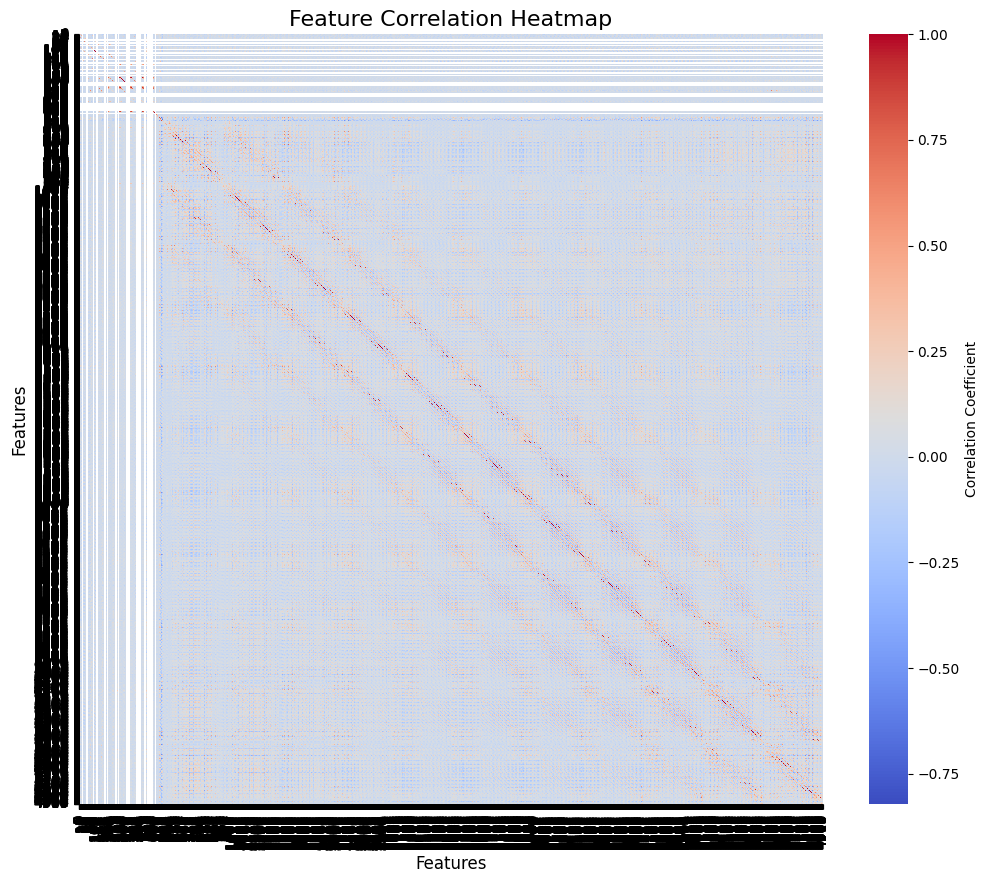

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Load the feature matrix from the CSV file
feature_df = pd.read_csv('feature_matrix.csv')

# Convert the DataFrame to a NumPy array (if you want to use NumPy functions)
feature_matrix = feature_df.values

# Standardize the feature matrix (important for better visualization)
scaler = StandardScaler()
feature_matrix_scaled = scaler.fit_transform(feature_matrix)

# Compute the correlation matrix
correlation_matrix = np.corrcoef(feature_matrix_scaled, rowvar=False)

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Create a heatmap using seaborn
sns.heatmap(correlation_matrix, annot=False, fmt=".2f", cmap='coolwarm',
            xticklabels=range(feature_matrix.shape[1]),
            yticklabels=range(feature_matrix.shape[1]),
            cbar_kws={"label": "Correlation Coefficient"})

# Set titles and labels
plt.title('Feature Correlation Heatmap', fontsize=16)
plt.xlabel('Features', fontsize=12)
plt.ylabel('Features', fontsize=12)

# Show the plot
plt.show()


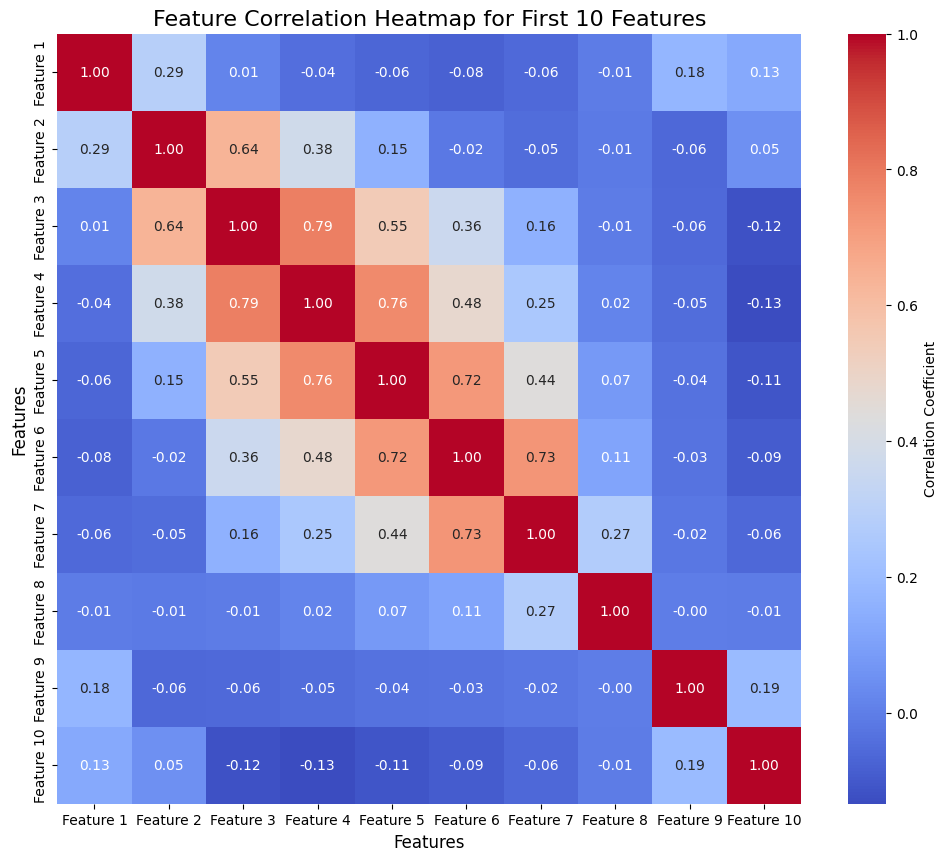

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Load the feature matrix from the CSV file
#feature_df = pd.read_csv('feature_matrix.csv')

# Select the first 10 features
feature_matrix = feature_df.iloc[:, :10].values  # Get first 10 columns as NumPy array

# Standardize the feature matrix (important for better visualization)
scaler = StandardScaler()
feature_matrix_scaled = scaler.fit_transform(feature_matrix)

# Compute the correlation matrix
correlation_matrix = np.corrcoef(feature_matrix_scaled, rowvar=False)

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Create a heatmap using seaborn
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm',
            xticklabels=[f'Feature {i+1}' for i in range(10)],  # Label features 1-10
            yticklabels=[f'Feature {i+1}' for i in range(10)],
            cbar_kws={"label": "Correlation Coefficient"})

# Set titles and labels
plt.title('Feature Correlation Heatmap for First 10 Features', fontsize=16)
plt.xlabel('Features', fontsize=12)
plt.ylabel('Features', fontsize=12)

# Show the plot
plt.show()


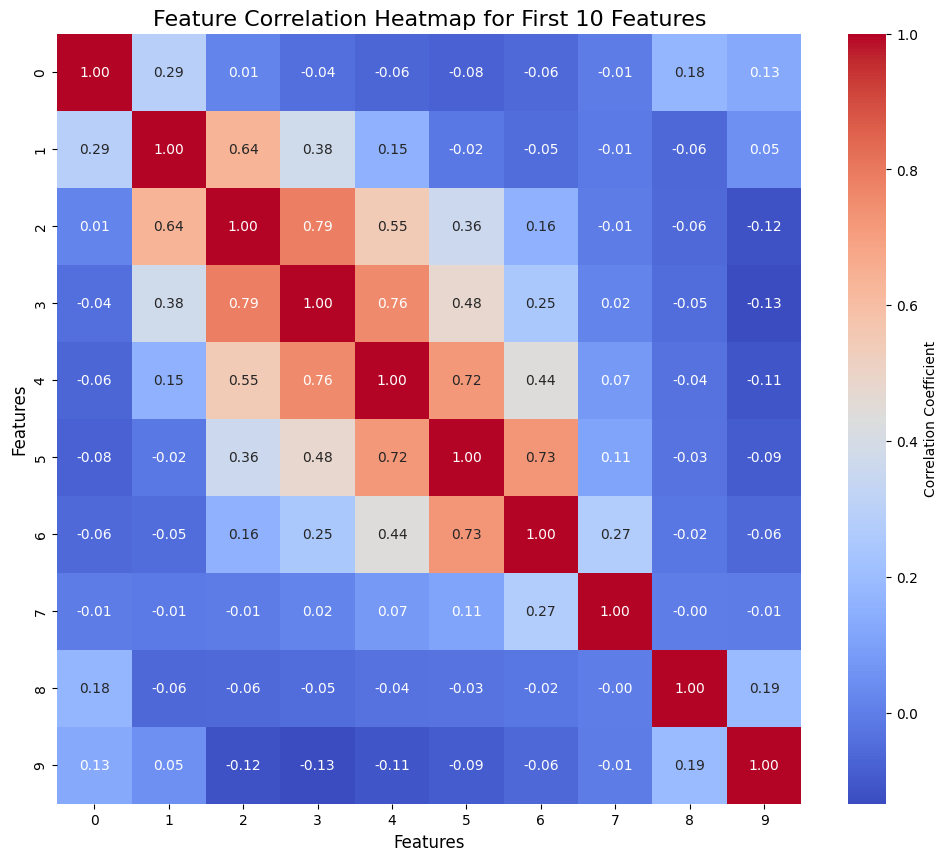

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler



# Select the first 10 features and their names
feature_names = feature_df.columns[:10]  # Get feature names for the first 10 columns
feature_matrix = feature_df.iloc[:, :10].values  # Get first 10 columns as NumPy array

# Standardize the feature matrix (important for better visualization)
scaler = StandardScaler()
feature_matrix_scaled = scaler.fit_transform(feature_matrix)

# Compute the correlation matrix
correlation_matrix = np.corrcoef(feature_matrix_scaled, rowvar=False)

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Create a heatmap using seaborn
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm',
            xticklabels=feature_names,  # Use actual feature names
            yticklabels=feature_names,
            cbar_kws={"label": "Correlation Coefficient"})

# Set titles and labels
plt.title('Feature Correlation Heatmap for First 10 Features', fontsize=16)
plt.xlabel('Features', fontsize=12)
plt.ylabel('Features', fontsize=12)

# Show the plot
plt.show()


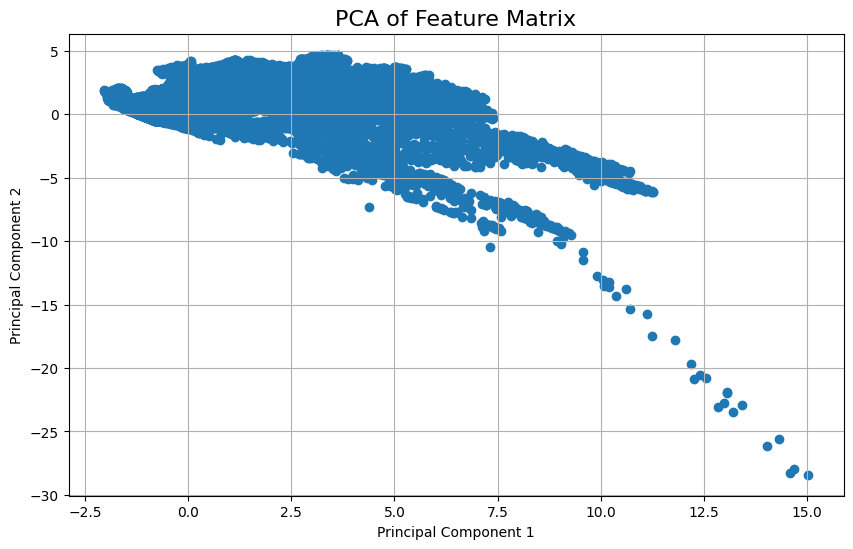

In [5]:
from sklearn.decomposition import PCA

# Perform PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(feature_matrix_scaled)

# Create a scatter plot of the first two principal components
plt.figure(figsize=(10, 6))
plt.scatter(principal_components[:, 0], principal_components[:, 1])
plt.title('PCA of Feature Matrix', fontsize=16)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid()
plt.show()


In [ ]:
from sklearn.manifold import TSNE

# Perform t-SNE
tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(feature_matrix_scaled)

# Create a scatter plot of the t-SNE results
plt.figure(figsize=(10, 6))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1])
plt.title('t-SNE of Feature Matrix', fontsize=16)
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.grid()
plt.show()


In [17]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances

# Example fruit names (substitute with your full list or selected ones)
fruit_combinations = [
    "Apple Golden 1",
    "Banana Red 1",
    "Cantaloupe 1",
    "Dragon Fruit 1",
    "Eggplant 1",
    "Grape Blue 1",
    "Kumquats 1",
    "Mango Red 1",
    "Pineapple 1",
    "Zucchini 1"
]


# Calculate the distance matrix using Euclidean distance
distance_matrix = pairwise_distances(train_features)

# Convert the distance matrix into a DataFrame for better visualization
import pandas as pd

# Create a DataFrame with the distance matrix and appropriate labels
distance_df = pd.DataFrame(distance_matrix, index=fruit_labels, columns=fruit_labels)

# Plotting the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(distance_df, annot=False, cmap='YlGnBu', cbar_kws={'label': 'Distance'})
plt.title("Heatmap of Distance Between Fruits")
plt.xlabel("Fruits")
plt.ylabel("Fruits")
plt.show()





NameError: name 'pairwise_distances' is not defined

In [ ]:
# Feature extraction functions
def extract_features(image):
    # Define the feature extraction functions
    def extract_color_histogram(image, bins=(8, 8, 8)):
        hist = cv2.calcHist([image], [0, 1, 2], None, bins, [0, 256, 0, 256, 0, 256])
        return cv2.normalize(hist, hist).flatten()

    def extract_glcm(image):
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        glcm = skimage.feature.graycomatrix(gray_image, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
        return glcm.flatten()[:10]

    def extract_hu_moments(image):
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        return cv2.HuMoments(cv2.moments(gray_image)).flatten()

    def extract_lbp(image, num_points=24, radius=8):
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        lbp = skimage.feature.local_binary_pattern(gray_image, num_points, radius, method="uniform")
        hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, num_points + 3), range=(0, num_points + 2))
        return hist.astype("float") / (hist.sum() + 1e-6)

    def extract_hog(image, pixels_per_cell=(8, 8), cells_per_block=(2, 2), orientations=9):
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        return skimage.feature.hog(gray_image, orientations=orientations, pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block, block_norm='L2-Hys', transform_sqrt=True, feature_vector=True)

    # Combine all features
    return np.hstack([extract_color_histogram(image), extract_glcm(image), extract_hu_moments(image), extract_lbp(image), extract_hog(image)])



In [ ]:
# Extract features in parallel
with Pool() as pool:
    train_features = pool.map(extract_features, train_images)



In [ ]:
# Dimensionality reduction with PCA
pca = IncrementalPCA(n_components=50)
train_features_reduced = pca.fit_transform(np.array(train_features))

# Encode labels
le = LabelEncoder()
encoded_labels = le.fit_transform(train_labels)


In [ ]:
# SVM training
svm_model = make_pipeline(StandardScaler(), svm.SVC(kernel='rbf', probability=True))
svm_model.fit(train_features_reduced, encoded_labels)


In [ ]:
# Find closest fruit using Euclidean distance
def find_closest_fruit(target_fruit_name, distance_threshold=5.0):
    target_index = le.transform([target_fruit_name])[0]
    target_vector = train_features_reduced[encoded_labels == target_index].mean(axis=0)
    distances = euclidean_distances([target_vector], train_features_reduced).flatten()

    closest_fruit_index = np.argmin(distances[distances > 0])  # Exclude self-distance
    closest_fruit_name = le.inverse_transform([encoded_labels[closest_fruit_index]])[0]
    closest_distance = distances[closest_fruit_index]

    return closest_fruit_name, closest_distance

# Get result for 'Apple Golden 1'
target_fruit_name = 'Apple Golden 1'
closest_fruit_name, closest_distance = find_closest_fruit(target_fruit_name)

print(f"Closest fruit to {target_fruit_name} is {closest_fruit_name} with a distance of {closest_distance:.2f}")



In [ ]:
# Visualization for the results
def plot_distances(fruit_names, distances):
    fig, ax = plt.subplots()
    ax.barh(fruit_names, distances, color='skyblue')
    ax.set_xlabel('Distance')
    ax.set_title('Closest Fruits to Target')
    plt.show()


In [ ]:
# Prepare data for visualization
fruit_names, distances = [], []
for _ in range(10):  # Get 10 closest
    fruit_name, distance = find_closest_fruit(target_fruit_name)
    fruit_names.append(fruit_name)
    distances.append(distance)

plot_distances(fruit_names, distances)